In [1]:
import glob, os, sys, re, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
import tqdm

In [2]:
def collect_seqs(pattern: str, label: str, genes: list, sp=False):
    directory = "../data/MIDORI2/fasta/"
    file = "MIDORI2_{}_NUC_SP_GB253_{}_BLAST.fasta" if sp else "MIDORI2_{}_NUC_GB253_{}_BLAST.fasta"
    path_to_fasta = directory + file
    seqs = defaultdict(list)
    for gene in tqdm.tqdm(genes):
        inp = path_to_fasta.format(label, gene)
        for rec in SeqIO.parse(inp, "fasta"):
            header = rec.description
            
            if pattern not in header:
                continue

            raw_acc, taxa = header.split("###")
            acc, place = re.match("(\w+\.\d)\.(.+)", raw_acc).groups()
            taxa = taxa.removeprefix("root_1;Eukaryota_2759;")
            species = " ".join(taxa.split(";")[-1].split("_")[:-1])
            rec.id = acc
            rec.description = f"{species} {place} ###{taxa}"
            seqs[gene + "__" + species.replace(" ", "_")].append(rec)
    return seqs


def filter_seqs(recs: list, var_gene_len=0.2, Nshare=0.2):
    assert isinstance(recs, list)
    seq_len_mean = np.median([len(x) for x in recs])
    min_seq_len = seq_len_mean * (1 - var_gene_len)
    max_seq_len = seq_len_mean * (1 + var_gene_len)

    recs_filtered = []
    for rec in recs:
        acgt_share = sum(rec.seq.count(x) for x in "ACGT") / len(rec)
        if min_seq_len < len(rec) < max_seq_len and 1 - acgt_share < Nshare:
            recs_filtered.append(rec)

    return recs_filtered


def filter_seqs_dict(seqs, nseqs_min=10, var_gene_len=0.2, Nshare=0.2):
    assert isinstance(seqs, dict)
    seqs_filtered = dict()
    for gene_species, recs in seqs.items():
        if len(recs) < nseqs_min:
            continue

        recs_filtered = filter_seqs(recs, var_gene_len, Nshare)
        if len(recs_filtered) >= nseqs_min:
            seqs_filtered[gene_species] = recs_filtered
    
    return seqs_filtered

## *Hominidae*

### CYTB

In [8]:
pattern = "Hominidae_9604"
seqs = collect_seqs(pattern, "UNIQ", ['Cytb'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.05)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 300
cytb_recs = []
for gene_sp, recs in seqs_filtered.items():
    print(gene_sp, len(recs))
    if len(recs) > MAX_SP_NSEQS:
        print(f"Sample {MAX_SP_NSEQS} seqs")
        recs = random.sample(recs, MAX_SP_NSEQS)
    cytb_recs.extend(recs)

cytb_recs_filtered = filter_seqs(cytb_recs, 0.1)

100%|██████████| 1/1 [00:04<00:00,  4.34s/it]

['Cytb__Gorilla_beringei', 'Cytb__Gorilla_gorilla', 'Cytb__Homo_heidelbergensis', 'Cytb__Homo_sapiens', 'Cytb__Pan_paniscus', 'Cytb__Pan_troglodytes', 'Cytb__Pongo_abelii', 'Cytb__Pongo_pygmaeus']
Cytb__Gorilla_beringei 8
Cytb__Gorilla_gorilla 1
Cytb__Homo_heidelbergensis 1
Cytb__Homo_sapiens 5703
Sample 300 seqs
Cytb__Pan_paniscus 19
Cytb__Pan_troglodytes 10
Cytb__Pongo_abelii 10
Cytb__Pongo_pygmaeus 9


In [11]:
gagp_cytb = filter_seqs([x for x in SeqIO.parse("../data/GAGP/genes/CYTB.fna", "fasta")], 0.1)

In [15]:
cytb_collection = []
visited = set()
ndropped = 0
for rec in cytb_recs_filtered + gagp_cytb:
    h = hash(rec.seq)
    if h not in visited:
        cytb_collection.append(rec)
        visited.add(h)
    else:
        ndropped += 1

print(ndropped)
len(cytb_collection), len(cytb_recs_filtered)

44


(366, 328)

In [21]:
SeqIO.write(cytb_collection, "../data/HOMINIDAE/genes/CYTB.fna", "fasta-2line")

366

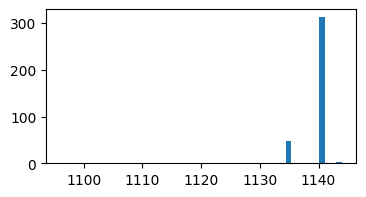

In [29]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cytb_collection], bins=50);

### ND1

In [19]:
pattern = "Hominidae_9604"
seqs = collect_seqs(pattern, "UNIQ", ['ND1'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.1)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 300
nd1_recs = []
for gene_sp, recs in seqs_filtered.items():
    print(gene_sp, len(recs))
    if len(recs) > MAX_SP_NSEQS:
        print(f"Sample {MAX_SP_NSEQS} seqs")
        recs = random.sample(recs, MAX_SP_NSEQS)
    nd1_recs.extend(recs)

nd1_recs_filtered = filter_seqs(nd1_recs, 0.1)

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

['ND1__Gorilla_beringei', 'ND1__Gorilla_gorilla', 'ND1__Homo_heidelbergensis', 'ND1__Homo_sapiens', 'ND1__Pan_paniscus', 'ND1__Pan_troglodytes', 'ND1__Pongo_abelii', 'ND1__Pongo_pygmaeus']
ND1__Gorilla_beringei 4
ND1__Gorilla_gorilla 6
ND1__Homo_heidelbergensis 1
ND1__Homo_sapiens 3771
Sample 300 seqs
ND1__Pan_paniscus 31
ND1__Pan_troglodytes 96
ND1__Pongo_abelii 3
ND1__Pongo_pygmaeus 4


In [18]:
gagp_nd1 = filter_seqs([x for x in SeqIO.parse("../data/GAGP/genes/ND1.fna", "fasta")], 0.1)

In [26]:
nd1_collection = []
visited = set()
ndropped = 0
for rec in nd1_recs_filtered + gagp_nd1:
    h = hash(rec.seq)
    if h not in visited:
        nd1_collection.append(rec)
        visited.add(h)
    else:
        ndropped += 1

print(ndropped)
len(nd1_collection), len(nd1_recs_filtered)

58


(469, 445)

In [27]:
SeqIO.write(nd1_collection, "../data/HOMINIDAE/genes/ND1.fna", "fasta-2line")

469

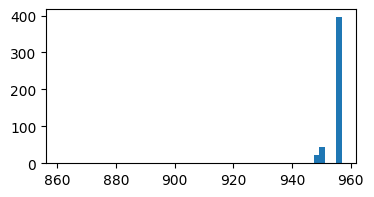

In [30]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in nd1_collection], bins=50);

## *Mus* genus

### CYTB

In [80]:
pattern = "Mus_10088"
seqs = collect_seqs(pattern, "UNIQ", ['Cytb'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.05)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 100
cytb_recs = []
for gene_sp, recs in seqs_filtered.items():
    if len(recs) > MAX_SP_NSEQS:
        print(gene_sp)
        recs = random.sample(recs, MAX_SP_NSEQS)
    cytb_recs.extend(recs)

cytb_recs_filtered = filter_seqs(cytb_recs, 0.1)

SeqIO.write(cytb_recs_filtered, "../data/MUS/genes/CYTB.fna", "fasta-2line")

100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

['Cytb__Mus_crociduroides', 'Cytb__Mus_mayori', 'Cytb__Mus_pahari', 'Cytb__Mus_booduga', 'Cytb__Mus_caroli', 'Cytb__Mus_cervicolor', 'Cytb__Mus_cookii', 'Cytb__Mus_cypriacus', 'Cytb__Mus_famulus', 'Cytb__Mus_fragilicauda', 'Cytb__Mus_lepidoides', 'Cytb__Mus_macedonicus', 'Cytb__Mus_musculus', 'Cytb__Mus_nitidulus', 'Cytb__Mus_poschiavinus', 'Cytb__Mus_spicilegus', 'Cytb__Mus_spretus', 'Cytb__Mus_terricolor', 'Cytb__Mus_triton', 'Cytb__Mus_baoulei', 'Cytb__Mus_callewaerti', 'Cytb__Mus_harennensis', 'Cytb__Mus_haussa', 'Cytb__Mus_indutus', 'Cytb__Mus_mahomet', 'Cytb__Mus_mattheyi', 'Cytb__Mus_minutoides', 'Cytb__Mus_musculoides', 'Cytb__Mus_neavei', 'Cytb__Mus_setulosus', 'Cytb__Mus_sorella', 'Cytb__Mus_tenellus', 'Cytb__Mus_fernandoni', 'Cytb__Mus_platythrix', 'Cytb__Mus_saxicola']
Cytb__Mus_musculus
Cytb__Mus_spretus


445

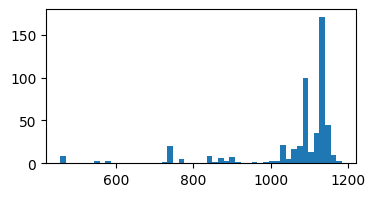

In [78]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cytb_recs], bins=50);

### ND1

In [75]:
pattern = "Mus_10088"
seqs = collect_seqs(pattern, "UNIQ", ['ND1'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.1)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 100
cytb_recs = []
for gene_sp, recs in seqs_filtered.items():
    if len(recs) > MAX_SP_NSEQS:
        print(gene_sp)
        recs = random.sample(recs, MAX_SP_NSEQS)
    cytb_recs.extend(recs)

cytb_recs_filtered = filter_seqs(cytb_recs, 0.1)

SeqIO.write(cytb_recs_filtered, "../data/MUS/genes/ND1.fna", "fasta-2line")

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

['ND1__Mus_pahari', 'ND1__Mus_caroli', 'ND1__Mus_cervicolor', 'ND1__Mus_cookii', 'ND1__Mus_famulus', 'ND1__Mus_fragilicauda', 'ND1__Mus_musculus', 'ND1__Mus_spretus', 'ND1__Mus_terricolor', 'ND1__Mus_baoulei', 'ND1__Mus_saxicola']


106

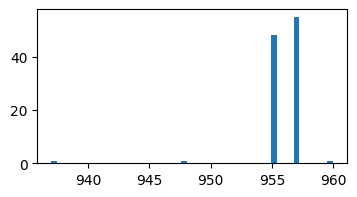

In [76]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cytb_recs], bins=50);

## *Mus musculus* & *Mus spretus*

In [44]:
genes = ['Cytb', 'ND1']
pattern1 = "Mus_musculus"
seqs1 = collect_seqs(pattern1, "UNIQ", genes)
seqs1_filtered = filter_seqs(seqs1, 1)

pattern2 = "Mus_spretus"
seqs2 = collect_seqs(pattern2, "UNIQ", genes)
seqs2_filtered = filter_seqs(seqs2, 1)

100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


In [55]:
seqs2_filtered["ND1__Mus_spretus"]

[SeqRecord(seq=Seq('GTGTTCTTTATCAACATTTTAACACTCCTCCTACCTATCCTAATCGCTATGGCT...TAT'), id='MW209725.1', name='MW209725.1.2746.3700###root_1;Eukaryota_2759;Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', description='Mus spretus 2746.3700 ###Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGTTCTTTATCAACATTTTAACACTCCTCCTACCTATCCTAATCGCTATGGCT...TAT'), id='KY018921.1', name='KY018921.1.2749.3703###root_1;Eukaryota_2759;Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', description='Mus spretus 2749.3703 ###Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', dbxrefs=[])]

In [53]:
seqs2_filtered.keys()

dict_keys(['Cytb__Mus_spretus', 'ND1__Mus_spretus'])

In [56]:
nd1 = []
g = "ND1"
for p, s in zip([pattern1, pattern2], [seqs1_filtered, seqs2_filtered]):
    for r in s[g+ "__" + p]:
        nd1.append(r)

cytb = []
g = "Cytb"
for p, s in zip([pattern1, pattern2], [seqs1_filtered, seqs2_filtered]):
    for r in s[g+ "__" + p]:
        cytb.append(r)

In [60]:
print(f"nseqs = {len(cytb)}")
print(f"nseqs = {len(nd1)}")

nseqs = 769
nseqs = 93


In [61]:
SeqIO.write(nd1, "../data/exposure/mus_nd1/seqs.fasta", "fasta-2line")
SeqIO.write(cytb, "../data/exposure/mus_cytb/seqs.fasta", "fasta-2line")

769

## *Arthropoda*

In [ ]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Arthropoda"
seqs_arth = collect_seqs(phylum, "UNIQ", genes)
len(seqs_arth)

In [26]:
seqs_arth_filtered = filter_seqs(seqs_arth)
print(f"nseqs = {len(seqs_arth_filtered)}, nspecies: {len(set([x.split('__')[1] for x in seqs_arth_filtered.keys()]))}", end="\n\n")
print(pd.Series(Counter([x.split("__")[0] for x in seqs_arth_filtered.keys()])))

nseqs = 19172, nspecies: 17676

A6         65
A8         24
CO1     17116
CO2       723
CO3        73
Cytb      549
ND1       151
ND2        83
ND3        28
ND4        82
ND4L       22
ND5       211
ND6        45
dtype: int64


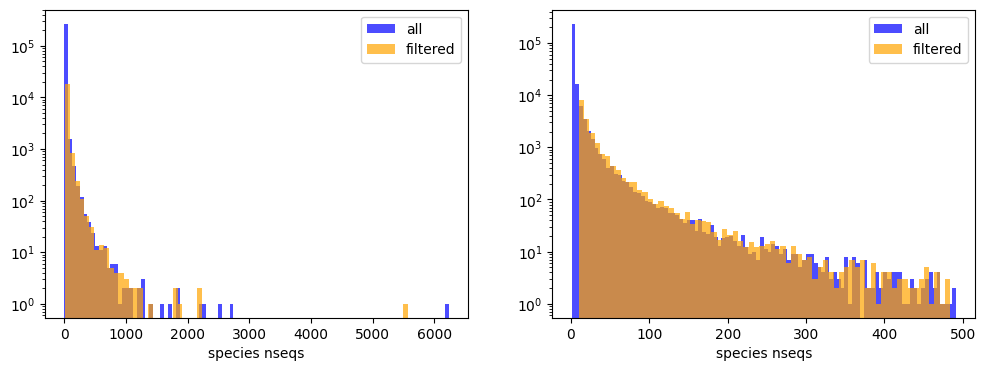

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([len(v) for v in seqs_arth.values()], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_arth_filtered.values()], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.subplot(122)
plt.hist([len(v) for v in seqs_arth.values() if len(v) < 500], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_arth_filtered.values() if len(v) < 500], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.show()

### Prepare dataset for CO1 alignment (outgrp selection)

In [20]:
arth_aln = collect_seqs(phylum, "LONGEST", ["CO1"])

100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


In [32]:
print(len(set([x.split("__")[1] for x in seqs_arth_filtered.keys()]).difference([x.split("__")[1] for x in arth_aln.keys()])), "species without CO1 seq")

136 species without CO1 seq


## Chordata

In [3]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Chordata"
seqs_uniq = collect_seqs(phylum, "UNIQ", genes)
len(seqs_uniq)

100%|██████████| 13/13 [00:38<00:00,  2.93s/it]


192350

In [4]:
seqs_uniq_filtered = filter_seqs_dict(seqs_uniq)
print(f"ngenes = {len(seqs_uniq_filtered)}, nspecies: {len(set([x.split('__')[1] for x in seqs_uniq_filtered.keys()]))}", end="\n\n")
print(pd.Series(Counter([x.split("__")[0] for x in seqs_uniq_filtered.keys()])))

ngenes = 15496, nspecies: 10163

A6       501
A8       185
CO1     5447
CO2      200
CO3      207
Cytb    4963
ND1      389
ND2     1902
ND3      250
ND4      831
ND4L     119
ND5      306
ND6      196
dtype: int64


In [5]:
co1_sp = [x.split("__")[1] for x in seqs_uniq_filtered.keys() if x.startswith("CO1")]
cytb_sp = [x.split("__")[1] for x in seqs_uniq_filtered.keys() if x.startswith("Cytb")]
len(set(co1_sp).intersection(cytb_sp))

1750

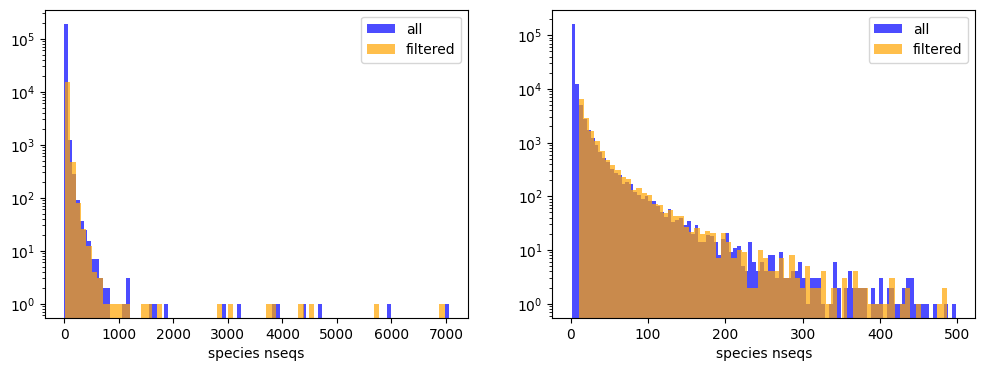

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([len(v) for v in seqs_uniq.values()], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_uniq_filtered.values()], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.subplot(122)
plt.hist([len(v) for v in seqs_uniq.values() if len(v) < 500], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_uniq_filtered.values() if len(v) < 500], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.show()

### Check genus-wise species distribution

In [7]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Chordata"
seqs_longest = collect_seqs(phylum, "LONGEST", genes, sp=True)

100%|██████████| 13/13 [00:15<00:00,  1.16s/it]


In [8]:
seqs_longest["A6__Branchiostoma_belcheri"][0].description

'Branchiostoma belcheri 8821.9504 ###Chordata_7711;Leptocardii_2682552;Amphioxiformes_2682553;Branchiostomatidae_7736;Branchiostoma_7737;Branchiostoma_belcheri_7741'

In [9]:
data_taxa = []
for gene_sp, seqs in seqs_uniq_filtered.items():
    raw_taxonomy = seqs[0].description.split("###")[1]
    phyl, clss, order, fam, genus, sp = ["_".join(x.split("_")[:-1]) for x in raw_taxonomy.split(";")]
    data_taxa.append(dict(gene=gene_sp.split('__')[0], clss=clss, order=order, fam=fam, genus=genus, species=sp, nseqs=len(seqs)))
genes_taxa_uniq = pd.DataFrame(data_taxa)

data_taxa = []
for gene_sp, seqs in seqs_longest.items():
    raw_taxonomy = seqs[0].description.split("###")[1]
    phyl, clss, order, fam, genus, sp = ["_".join(x.split("_")[:-1]) for x in raw_taxonomy.split(";")]
    data_taxa.append(dict(gene=gene_sp.split('__')[0], clss=clss, order=order, fam=fam, genus=genus, species=sp))
genes_taxa_longest = pd.DataFrame(data_taxa)
del data_taxa

In [10]:
genes_taxa_uniq

,gene,clss,order,fam,genus,species,nseqs
0,A6,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_belcheri,15
1,A6,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_floridae,20
2,A6,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_lanceolatum,10
3,A6,Hyperoartia,Petromyzontiformes,Petromyzontidae,Lampetra,Lampetra_fluviatilis,37
4,A6,Hyperoartia,Petromyzontiformes,Petromyzontidae,Lampetra,Lampetra_planeri,28
...,...,...,...,...,...,...,...
15491,ND6,Amphibia,Caudata,Cryptobranchidae,Andrias,Andrias_davidianus,25
15492,ND6,Amphibia,Caudata,Hynobiidae,Pachyhynobius,Pachyhynobius_shangchengensis,22
15493,ND6,Amphibia,Caudata,Hynobiidae,Salamandrella,Salamandrella_keyserlingii,15
15494,ND6,Amphibia,Caudata,Plethodontidae,Eurycea,Eurycea_spelaea,10


In [11]:
nonstandart_names = genes_taxa_uniq[genes_taxa_uniq.species.str.count("_") > 1].species.str.split("_")\
    .apply(lambda x: x[:2]).str.join("_").unique()

genes_taxa_uniq[genes_taxa_uniq.species.isin(nonstandart_names)].shape
# So, drop these broken species names

(54, 7)

In [12]:
genes_taxa_uniq = genes_taxa_uniq[genes_taxa_uniq.species.str.count("_") == 1]
genes_taxa_uniq.shape

(15463, 7)

In [13]:
(genes_taxa_longest[genes_taxa_longest.genus.isin(genes_taxa_uniq.genus)].groupby("genus").species.unique().apply(len) == 1).sum()

590

In [11]:
a = genes_counts.groupby("gene").genus.value_counts()
a[a==1]

gene  genus                                                      
A6    Abalistes                                                      1
      Abantennarius                                                  1
      Ablennes                                                       1
      Aborichthys                                                    1
      Abramis                                                        1
                                                                    ..
ND6   genus_Tachysurus_fulvidraco_x_Leiocassis_longirostris          1
      genus_diploid_Megalobrama_amblycephala_x_Xenocypris_davidi     1
      genus_diploid_Xenocypris_davidi_x_Megalobrama_amblycephala     1
      genus_natural_gynogenetic_Carassius_auratus_red_var.           1
      genus_triploid_Megalobrama_amblycephala_x_Xenocypris_davidi    1
Name: genus, Length: 38440, dtype: int64

In [12]:
a = genes_counts.groupby("gene").fam.value_counts()
a[a==1]

gene  fam                                                               
A6    Aenigmachannidae                                                      1
      Ailiidae                                                              1
      Amarsipidae                                                           1
      Amiidae                                                               1
      Amphiumidae                                                           1
                                                                           ..
ND6   family_genus_Squaliobarbus_curriculus_x_Ctenopharyngodon_idella       1
      family_genus_diploid_Megalobrama_amblycephala_x_Xenocypris_davidi     1
      family_genus_diploid_Xenocypris_davidi_x_Megalobrama_amblycephala     1
      family_genus_natural_gynogenetic_Carassius_auratus_red_var.           1
      family_genus_triploid_Megalobrama_amblycephala_x_Xenocypris_davidi    1
Name: fam, Length: 4116, dtype: int64

### Derive TimeTree

#### Rename broken leaf names

In [15]:
tt_species = pd.read_csv("../data/chordata/timetree_species.txt", header=None, sep="\t", names=["species"])
tt_species["new"] = tt_species.species
tt_species.loc[tt_species.new.str.contains("[^a-zA-Z_]"), "new"] = "None"
tt_species.to_csv("../data/chordata/species_mapper.txt", header=None, index=None, sep="\t")

In [16]:
!nw_rename ../data/chordata/chordates_species_total.txt ../data/chordata/species_mapper.txt > ../data/chordata/chordates_species_total_filtered.nwk

#### Read trees

In [45]:
timetree_genus = PhyloTree("../data/chordata/chordates_genus.nwk", format=1)
timetree_species = PhyloTree("../data/chordata/chordates_species_total_filtered.nwk", format=1)

timetree_species.search_nodes(name="Tenebrosternarchus_preto")[0].delete() # have dublicat
timetree_species.describe()

Number of leaf nodes:	38620
Total number of nodes:	77234
Rooted:	Yes
Most distant node:	Sitta_whiteheadi
Max. distance:	588.455150


In [46]:
timetree_species.prune(set(genes_taxa_longest.species.unique()).intersection(timetree_species.get_leaf_names()), True)
timetree_species.describe()

Number of leaf nodes:	32481
Total number of nodes:	64961
Rooted:	Yes
Most distant node:	Myioborus_cardonai
Max. distance:	588.455150


In [48]:
timetree_species.write(outfile="../data/chordata/chordates_species_total_filtered_twice.nwk", format=1)

In [99]:
hs = timetree_genus.search_nodes(name="Homo")[0]
print(hs.up.up.up.get_ascii(attributes=["name", "dist"]))


                            /-Gorilla, 8.6
                /'17045', 6.6
               |           |            /-Homo, 6.4
-'17044', 4.25714           \'17047', 2.2
               |                        \-Pan, 6.4
               |
                \-Pongo, 15.2


In [16]:
def get_closest_leaf(leaf):
    d = 0
    for x in leaf.up.children:
        if x.name != leaf.name:
            d += x.dist
            leaf_closest, d2 = x.get_closest_leaf()
            d += d2
            break
    return leaf_closest, d

In [19]:
genes_taxa_uniq.species.unique()

array(['Branchiostoma_belcheri', 'Branchiostoma_floridae',
       'Branchiostoma_lanceolatum', ..., 'Phylloscopus_plumbeitarsus',
       'Mustela_itatsi', 'Odorrana_supranarina'], dtype=object)

In [36]:
for n1 in tqdm.tqdm(timetree_species.iter_leaves()):
    for n2 in timetree_species.iter_leaves():
        d = timetree_species.get_distance(n1, n2)

15it [00:28,  1.91s/it]


KeyboardInterrupt: 

In [31]:
%timeit timetree_species.get_leaves_by_name("Asymmetron_lucayanum")
%timeit timetree_species.search_nodes(name="Asymmetron_lucayanum")

124 ms ± 780 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 486 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
data_closest = []
target_species = set(genes_taxa_uniq.species.unique())
for leaf in timetree_species.iter_leaves():
    if leaf.name in target_species:
        name = "_".join(leaf.name.split("_")[:2])
        closest, d = get_closest_leaf(leaf)
        data_closest.append([name, "_".join(closest.name.split("_")[:2]), d])
    
df_closest = pd.DataFrame(data_closest, columns=["species", "closest_species", "dist"]).drop_duplicates(subset="species")
df_closest

,species,closest_species,dist
0,Asymmetron_lucayanum,Asymmetron_inferum,66.85812
1,Branchiostoma_japonicum,Branchiostoma_belcheri,21.92519
2,Branchiostoma_belcheri,Branchiostoma_japonicum,21.92519
3,Branchiostoma_lanceolatum,Branchiostoma_floridae,61.74430
4,Branchiostoma_floridae,Branchiostoma_lanceolatum,61.74430
...,...,...,...
8473,Diplosoma_listerianum,Cystodytes_dellechiajei,117.22400
8474,Molgula_manhattensis,Molgula_tectiformis,130.30300
8475,Halocynthia_roretzi,Styela_plicata,276.59950
8476,Styela_plicata,Botryllus_schlosseri,196.91150


In [59]:
taxa = genes_counts.drop(["gene", "nseqs"], axis=1).drop_duplicates()
taxa

,clss,order,fam,genus,species
0,Leptocardii,Amphioxiformes,Branchiostomatidae,Asymmetron,Asymmetron_sp__A_TK_2007
1,Leptocardii,Amphioxiformes,Branchiostomatidae,Asymmetron,Asymmetron_inferum
2,Leptocardii,Amphioxiformes,Branchiostomatidae,Asymmetron,Asymmetron_lucayanum
3,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_belcheri
4,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_floridae
...,...,...,...,...,...
218180,Aves,Passeriformes,Estrildidae,Vidua,Vidua_codringtoni
218185,Aves,Passeriformes,Estrildidae,Vidua,Vidua_larvaticola
218187,Aves,Passeriformes,Estrildidae,Vidua,Vidua_maryae
218188,Aves,Passeriformes,Estrildidae,Vidua,Vidua_nigeriae


In [58]:
taxa.merge(df_closest, on="species")

,clss,order,fam,genus,species,closest_species,dist
0,Leptocardii,Amphioxiformes,Branchiostomatidae,Asymmetron,Asymmetron_lucayanum,Branchiostoma_japonicum,136.68200
1,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_belcheri,Branchiostoma_japonicum,21.92519
2,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_floridae,Branchiostoma_lanceolatum,61.74430
3,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_japonicum,Branchiostoma_belcheri,21.92519
4,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_lanceolatum,Branchiostoma_floridae,61.74430
...,...,...,...,...,...,...,...
8514,Amphibia,Anura,Limnodynastidae,Limnodynastes,Limnodynastes_dumerilii,Limnodynastes_peronii,28.31943
8515,Amphibia,Anura,Limnodynastidae,Limnodynastes,Limnodynastes_peronii,Limnodynastes_tasmaniensis,11.75912
8516,Amphibia,Caudata,Salamandridae,Triturus,Triturus_ivanbureschi,Triturus_karelinii,8.14465
8517,Amphibia,Anura,Ranidae,Odorrana,Odorrana_supranarina,Odorrana_narina,8.19060


In [27]:
closest

(PhyloTree node 'Branchiostoma_japonicum' (0x7f1f32e9861), 136.682)

In [32]:
print(leaf.up.get_ascii(attributes=["name", "dist"]))


               /-Styela_plicata, 196.9115
-'18302', 79.688
               \-Botryllus_schlosseri, 196.9115


In [21]:
timetree_genus.search_nodes(name="dfs")

[]

In [18]:
get_closest_leaf(leaf)

(PhyloTree node 'Epigonichthys' (0x7f1f416a4b2), 136.682)

In [20]:
get_closest_leaf(leaf.up.children[1].get_closest_leaf()[0])

(PhyloTree node 'Branchiostoma' (0x7f1f416a4a9), 118.91972)

In [19]:
leaf.up.children[1].get_closest_leaf()[0]

PhyloTree node 'Epigonichthys' (0x7f1f416a4b2)

In [129]:
leaf.get_closest_leaf()

(PhyloTree node 'Asymmetron' (0x7fd4497defa), 0.0)